In [12]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler,LabelBinarizer
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor ,RandomForestRegressor ,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)

In [13]:
# Loading Train data

df = pd.read_csv('Train.csv')

# Making copy of df and checking its shape
cdf = df.copy()
cdf.shape

(15000, 44)

In [14]:
# Creating functions to get the categorical and numerical columns of the dataset. 

def num_cols(dataframe):
    num_col_list = dataframe.select_dtypes(include=np.number).columns.to_list()
    return num_col_list
numeric_columns_list = num_cols(cdf)
print("Numeric Columns :\n",numeric_columns_list)

def cat_cols(dataframe):
    cat_col_list = dataframe.select_dtypes(exclude=np.number).columns.to_list()
    return cat_col_list
categorical_columns_list = cat_cols(cdf)
print('\nCategorical Columns :\n',categorical_columns_list)

Numeric Columns :
 ['ID', 'age', 'region_code', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun', 'card_lim', 'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may', 'credit_count_may', 'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun', 'emi_active', 'cc_cons']

Categorical Columns :
 ['account_type', 'gender', 'loan_enq']


In [15]:
# Search for missing values

def missing_values(dataframe):
    null_values = dataframe.isnull().sum()
    null_percent = dataframe.isnull().sum()/len(dataframe)*100
    null_df = pd.concat([null_values,null_percent],keys=['Value','Percent'],axis=1)
    return null_df

missing_values(cdf)

,Value,Percent
ID,0,0.0
account_type,0,0.0
gender,0,0.0
age,0,0.0
region_code,0,0.0
cc_cons_apr,0,0.0
dc_cons_apr,0,0.0
cc_cons_may,0,0.0
dc_cons_may,0,0.0
cc_cons_jun,0,0.0


In [16]:
# Checking for class imbalance

def class_imbalance(target):
    percent_balance = target.value_counts()/len(target)*100
    return percent_balance

print('Account Type\n',class_imbalance(cdf.account_type))
print('\nGender\n',class_imbalance(cdf.gender))
print('\nLoan Enquiry\n',class_imbalance(cdf.loan_enq))

Account Type
 current    84.846667
saving     15.153333
Name: account_type, dtype: float64

Gender
 M    86.3
F    13.7
Name: gender, dtype: float64

Loan Enquiry
 Y    100.0
Name: loan_enq, dtype: float64


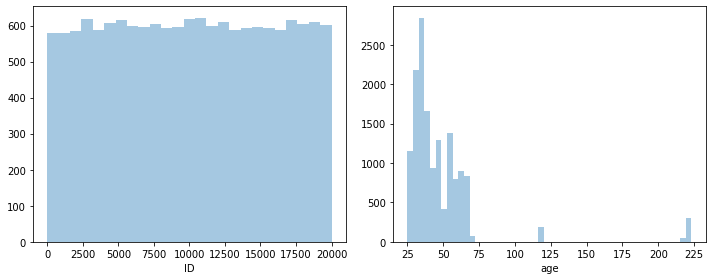

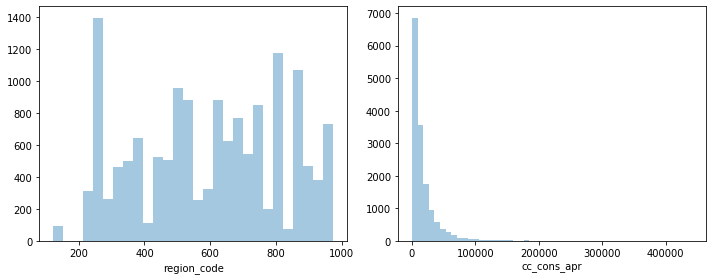

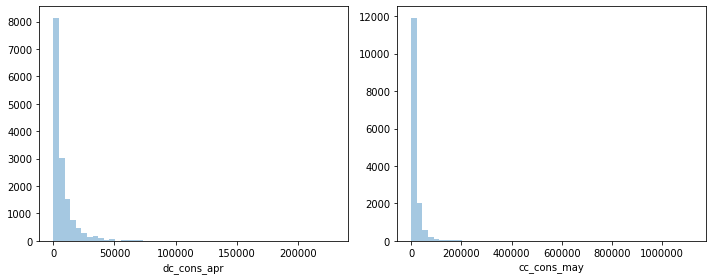

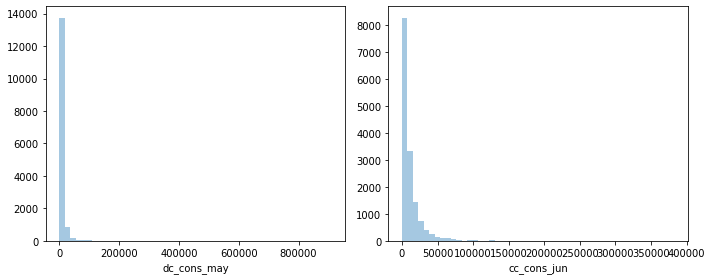

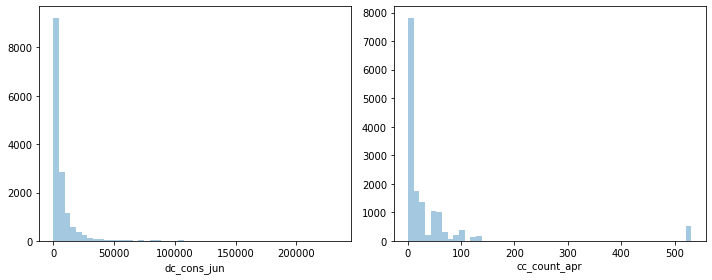

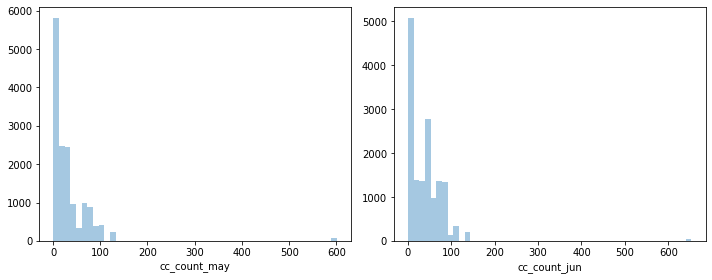

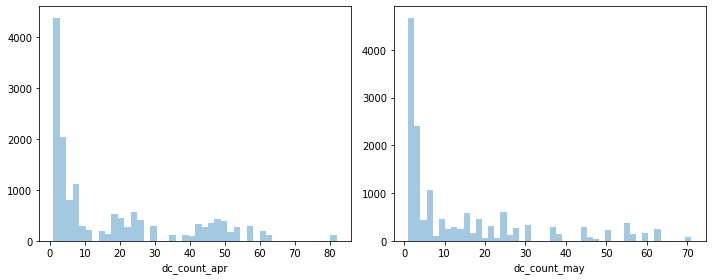

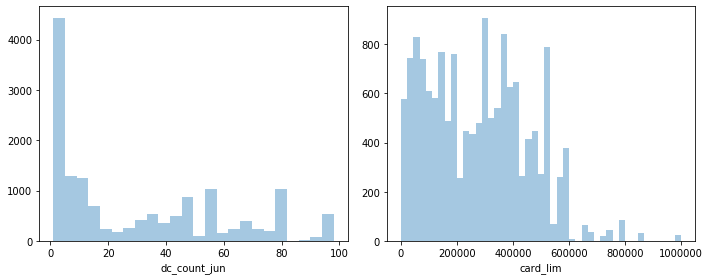

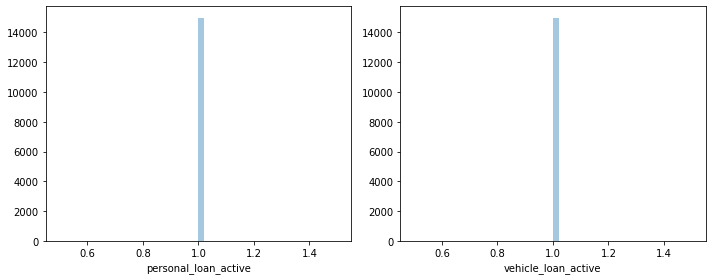

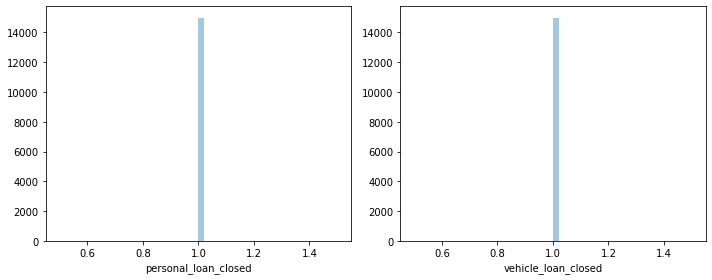

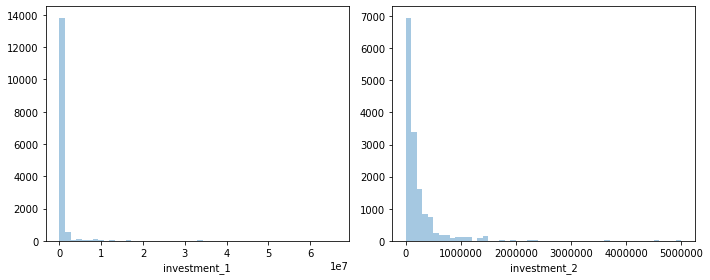

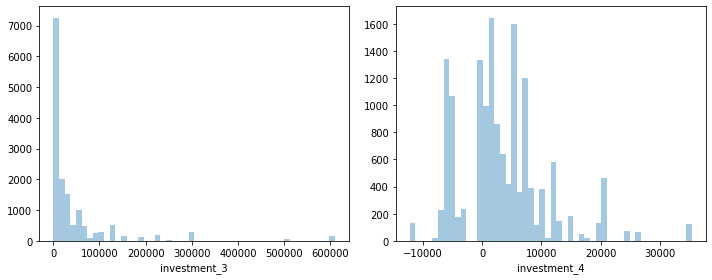

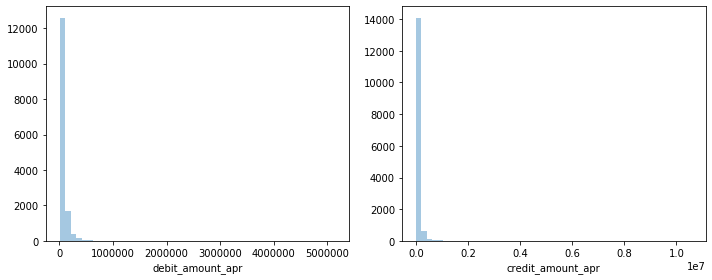

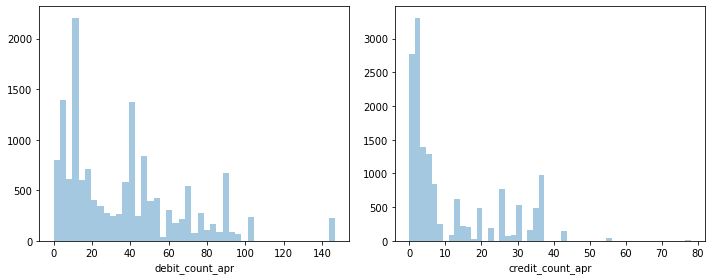

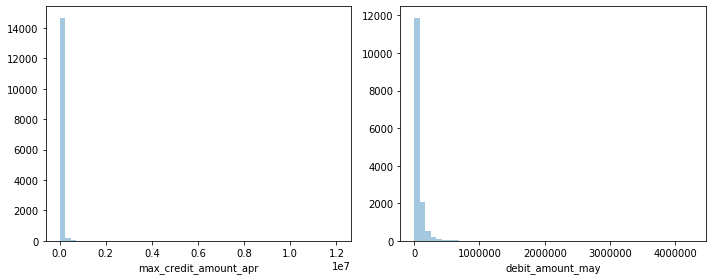

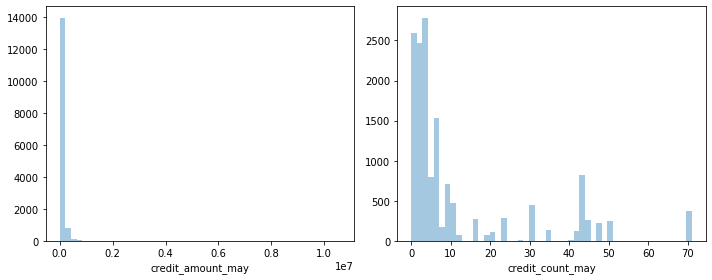

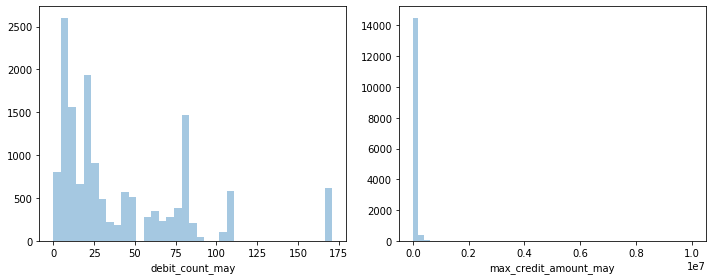

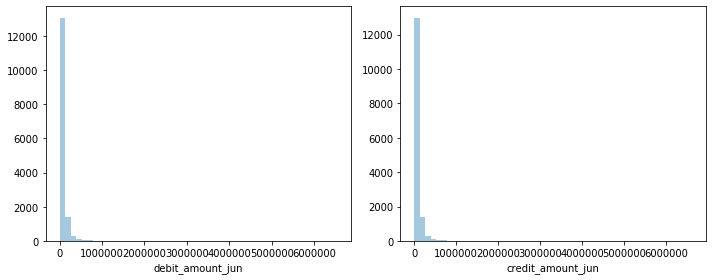

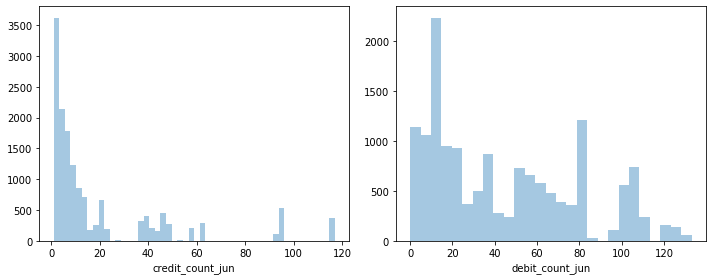

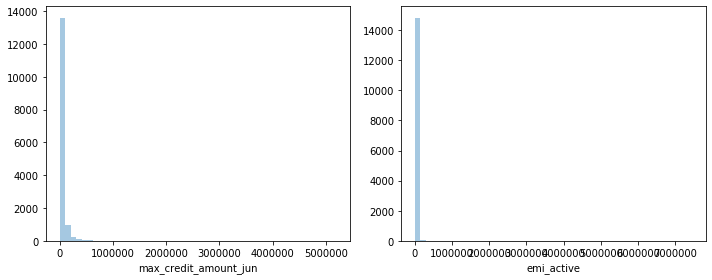

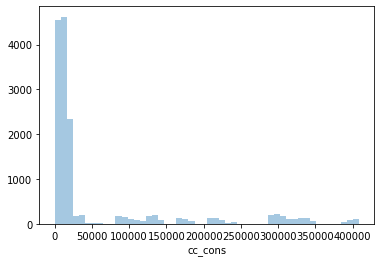

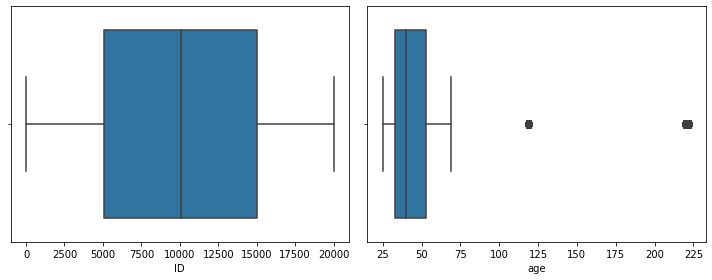

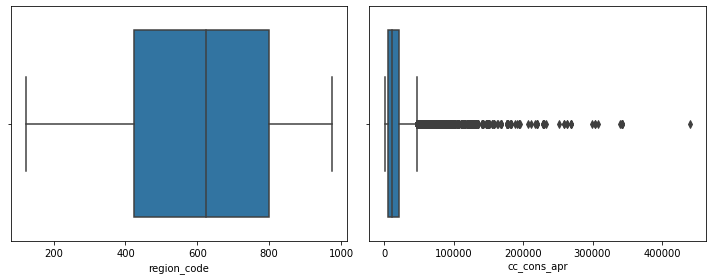

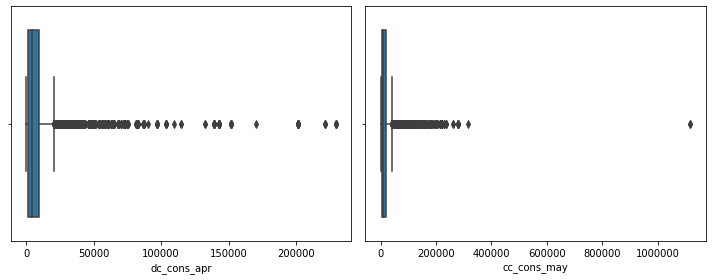

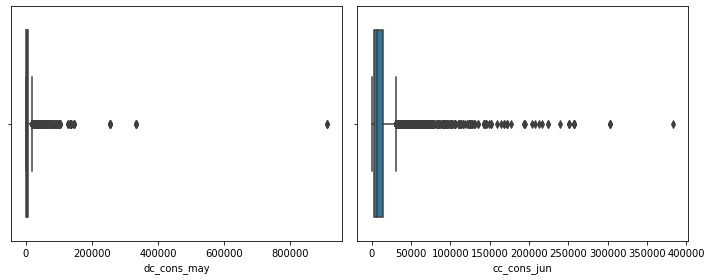

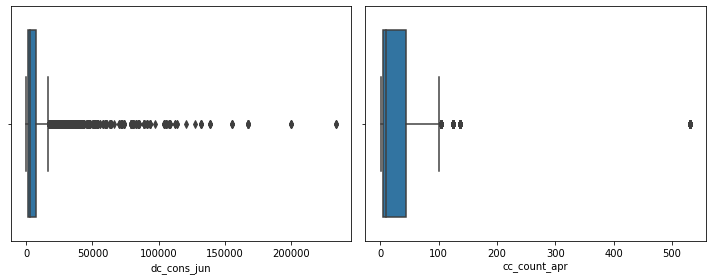

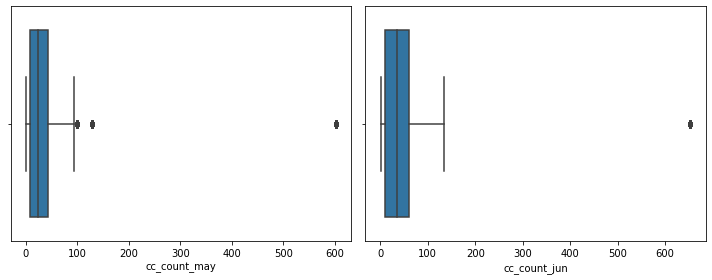

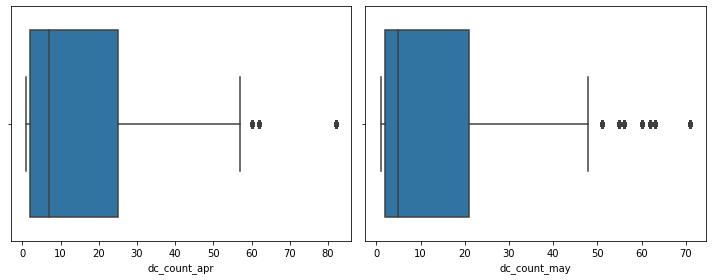

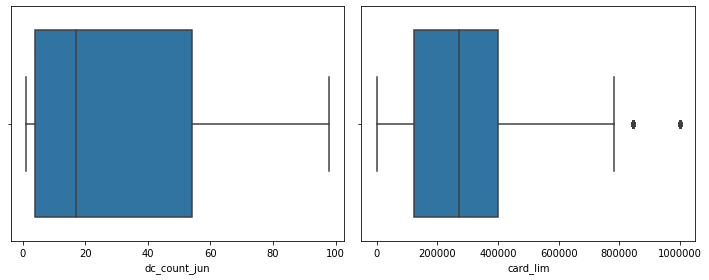

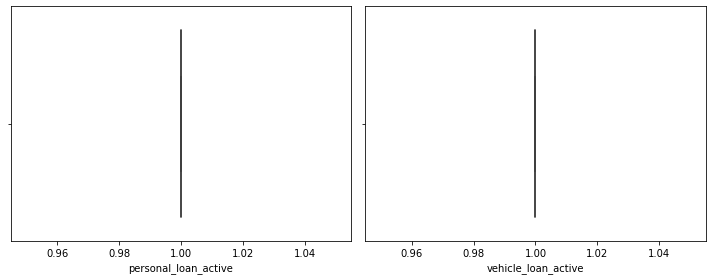

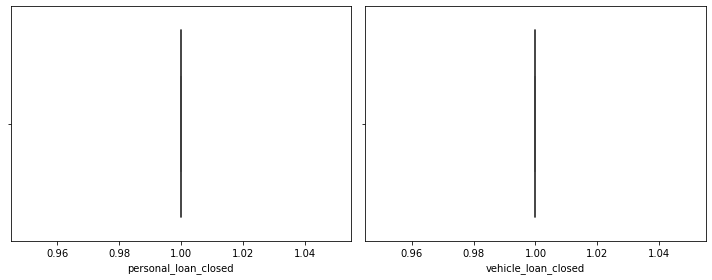

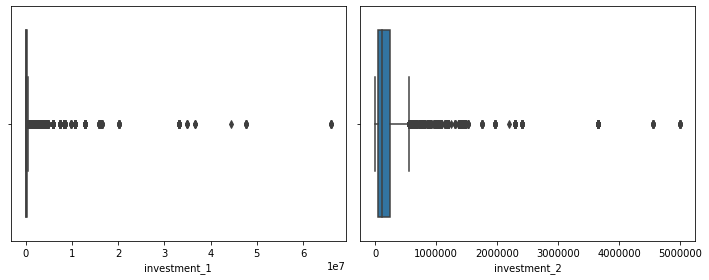

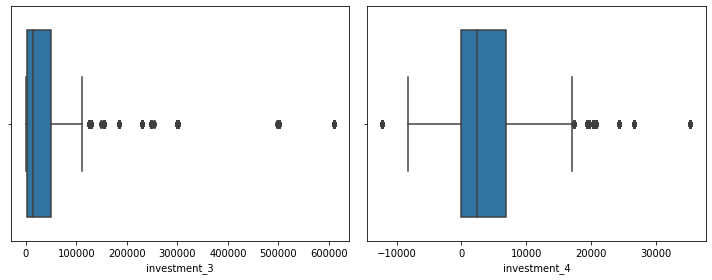

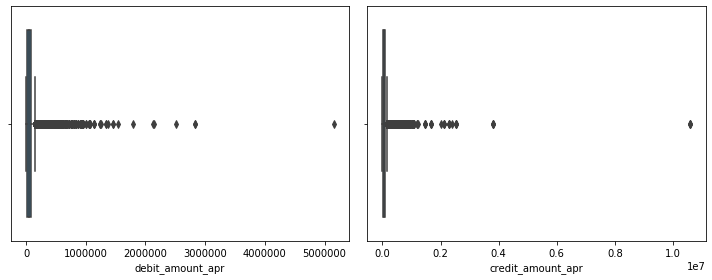

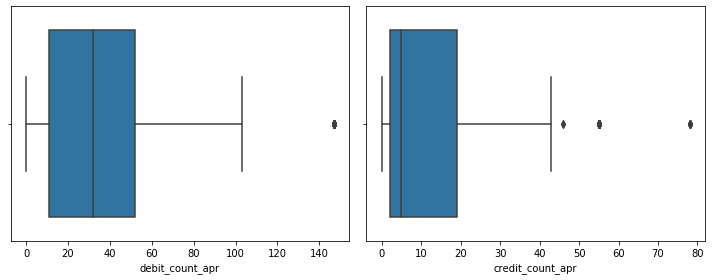

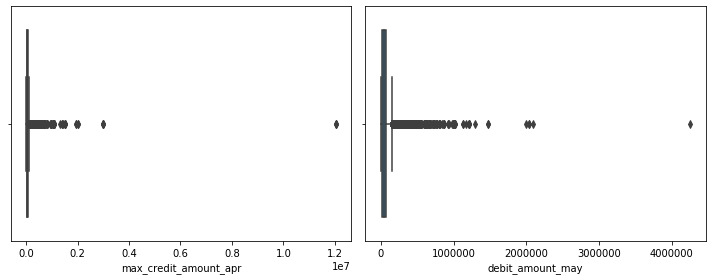

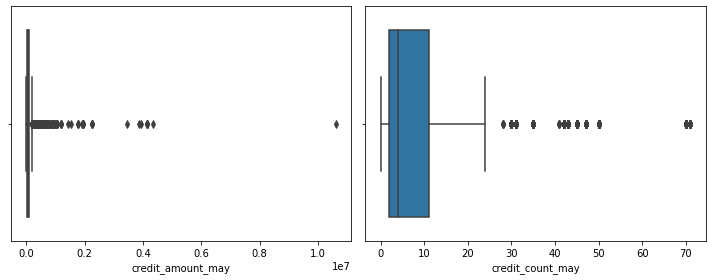

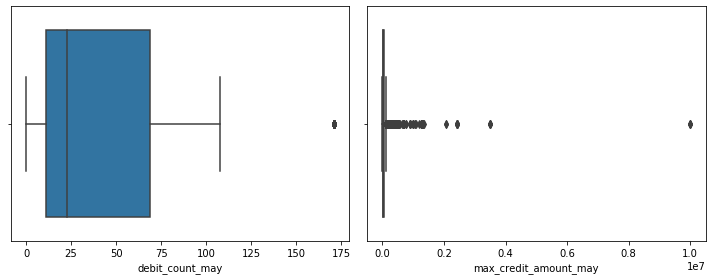

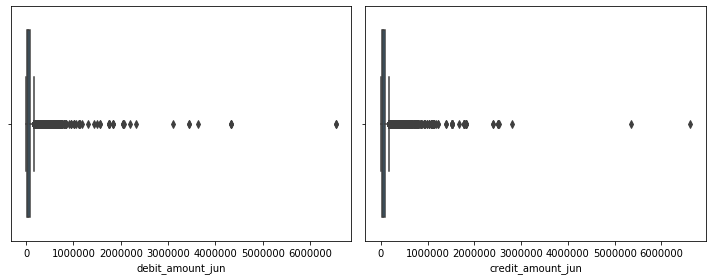

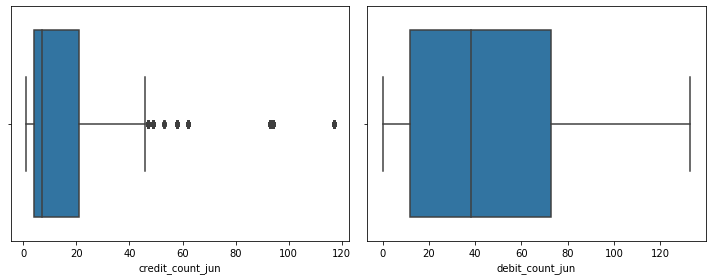

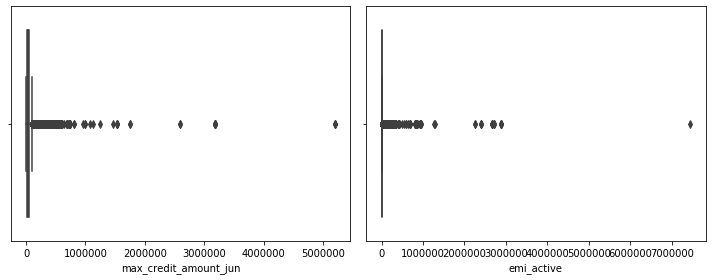

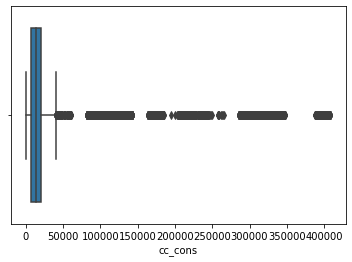

In [17]:
# Function to plot histograms

def plot_continuous_columns(dataframe):
    numeric_columns = dataframe.select_dtypes(include=['number']).columns.tolist()
    dataframe = dataframe[numeric_columns]
    
    for i in range(0,len(numeric_columns),2):
        if len(numeric_columns) > i+1:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            sns.distplot(dataframe[numeric_columns[i]], kde=False)
            plt.subplot(122)            
            sns.distplot(dataframe[numeric_columns[i+1]], kde=False)
            plt.tight_layout()
            plt.show()

        else:
            sns.distplot(dataframe[numeric_columns[i]], kde=False)

# Function to plot boxplots

def plot_box_plots(dataframe):
    numeric_columns = dataframe.select_dtypes(include=['number']).columns.tolist()
    dataframe = dataframe[numeric_columns]
    
    for i in range(0,len(numeric_columns),2):
        if len(numeric_columns) > i+1:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            sns.boxplot(dataframe[numeric_columns[i]])
            plt.subplot(122)            
            sns.boxplot(dataframe[numeric_columns[i+1]])
            plt.tight_layout()
            plt.show()

        else:
            sns.boxplot(dataframe[numeric_columns[i]])

plot_continuous_columns(cdf)            
plot_box_plots(cdf)


In [18]:
# Function to detect outliers in every feature
def detect_outliers(dataframe):
    cols = list(dataframe)
    outliers = pd.DataFrame(columns=['Feature','Number of Outliers'])
    
    for column in cols:
        if column in dataframe.select_dtypes(include=np.number).columns:
            # first quartile (Q1)
            q1 = dataframe[column].quantile(0.25) 
            
            # third quartile (Q3)
            q3 = dataframe[column].quantile(0.75)
            
            # IQR
            iqr = q3 - q1
            
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)
            outliers = outliers.append({'Feature':column,'Number of Outliers':dataframe.loc[(dataframe[column] < fence_low) \
            | (dataframe[column] > fence_high)].shape[0]},ignore_index=True)
    return outliers

detect_outliers(cdf)

,Feature,Number of Outliers
0,ID,0
1,age,534
2,region_code,0
3,cc_cons_apr,1217
4,dc_cons_apr,1220
5,cc_cons_may,1202
6,dc_cons_may,1248
7,cc_cons_jun,1181
8,dc_cons_jun,1366
9,cc_count_apr,883


In [19]:
# Function to treat outliers 

def treat_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.05, 0.1],inclusive=(True, True))
    
    return dataframe    


cdf = treat_outliers(cdf)

# Checking for outliers after applying winsorization
detect_outliers(cdf)



,Feature,Number of Outliers
0,ID,0
1,age,0
2,region_code,0
3,cc_cons_apr,0
4,dc_cons_apr,0
5,cc_cons_may,0
6,dc_cons_may,0
7,cc_cons_jun,0
8,dc_cons_jun,0
9,cc_count_apr,0


In [20]:
# Creating new columns by taking average of similar column values of three different months.

cdf['total_cc_cons'] = (cdf.cc_cons_apr + cdf.cc_cons_may + cdf.cc_cons_jun)
cdf['total_dc_cons'] = (cdf.dc_cons_apr + cdf.dc_cons_may + cdf.dc_cons_jun)
cdf['total_cc_count'] = (cdf.cc_count_apr + cdf.cc_count_may + cdf.cc_count_jun)
cdf['total_dc_count'] = (cdf.dc_count_apr + cdf.dc_count_may + cdf.dc_count_jun)
cdf['total_debit_amount'] = (cdf.debit_amount_apr + cdf.debit_amount_may + cdf.debit_amount_jun)
cdf['total_credit_amount'] = (cdf.credit_amount_apr + cdf.credit_amount_may + cdf.credit_amount_jun)
cdf['total_debit_count'] = (cdf.debit_count_apr + cdf.debit_count_may + cdf.debit_count_jun)
cdf['total_credit_count'] = (cdf.credit_count_apr + cdf.credit_count_may + cdf.credit_count_jun)
cdf['total_investments'] = (cdf.investment_1 + cdf.investment_2 + cdf.investment_3 + cdf.investment_4)

In [21]:
# Dropping columns that were used to make new columns by taking their average and saving it in a new DataFrame. 

cdf_cleaned = cdf.drop(['cc_cons_apr','cc_cons_may','cc_cons_jun','dc_cons_apr','dc_cons_may','dc_cons_jun',\
                     'cc_count_apr','cc_count_may','cc_count_jun','dc_count_apr','dc_count_may','dc_count_jun',\
                    'investment_1','investment_2','investment_3','investment_4',\
                    'personal_loan_active','personal_loan_closed','vehicle_loan_active','vehicle_loan_closed',\
                    'debit_amount_apr','debit_amount_may','debit_amount_jun',\
                     'credit_amount_apr','credit_amount_may','credit_amount_jun',\
                    'loan_enq','debit_count_apr','credit_count_apr','debit_count_may','credit_count_may',\
                    'debit_count_jun','credit_count_jun'],axis=1)

# Dropping column ID 

cdf_cleaned.drop('ID',axis=1,inplace=True)

# Dropping account_type and genders because of high class imbalance 

cdf_cleaned.drop(['account_type','gender'],axis=1,inplace=True)

In [22]:
# Label Encoding account_type and gender and adding it back to the cleaned data
df_cat = df[['account_type','gender']]
lb = LabelBinarizer()
for col in df_cat.columns:
    df_cat[col] = lb.fit

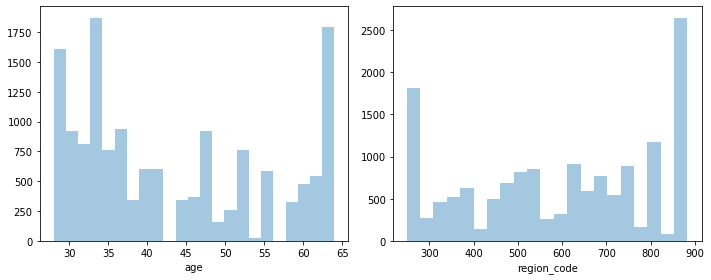

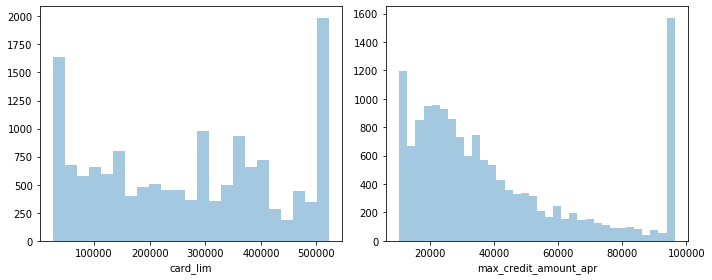

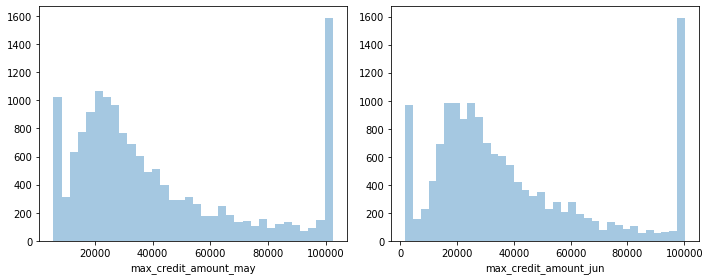

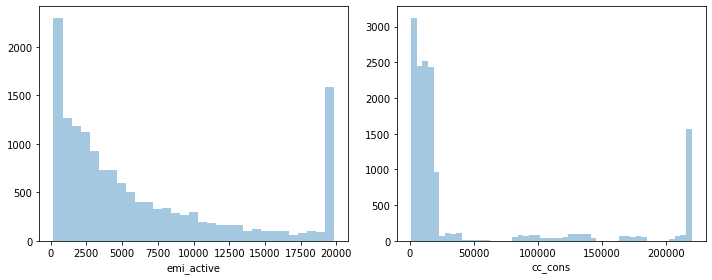

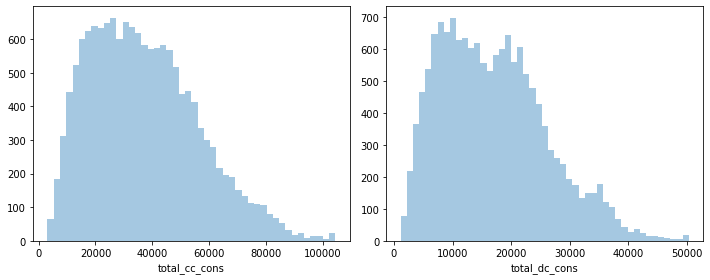

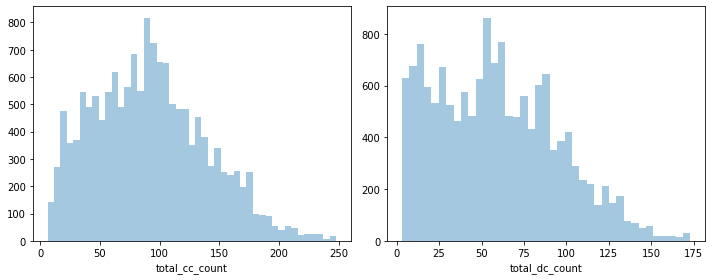

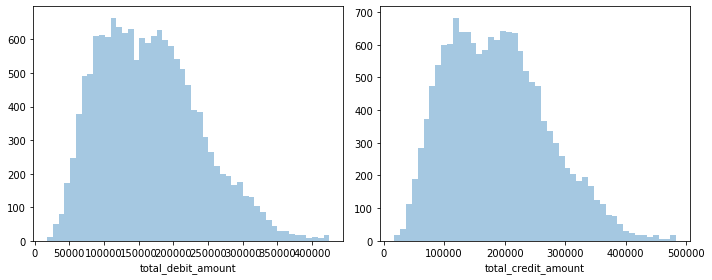

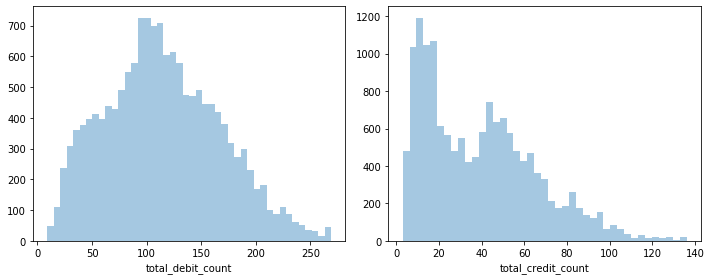

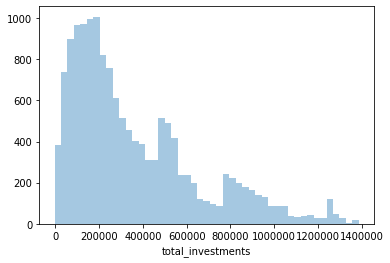

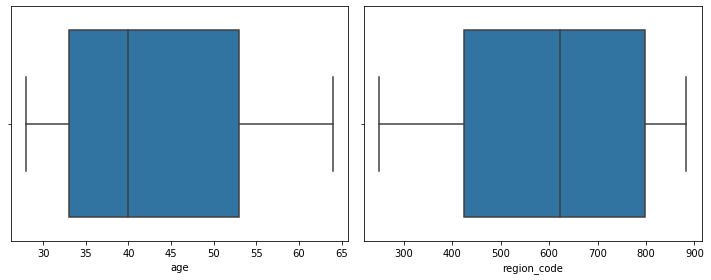

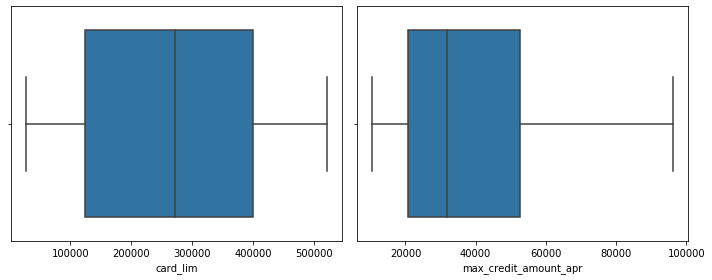

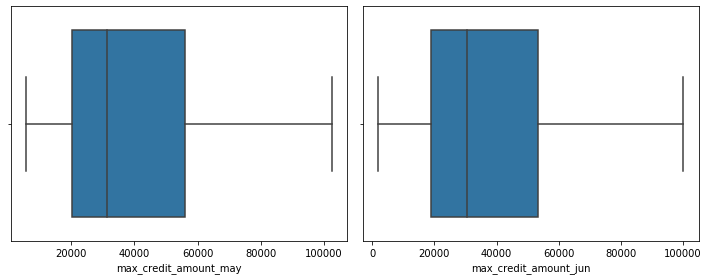

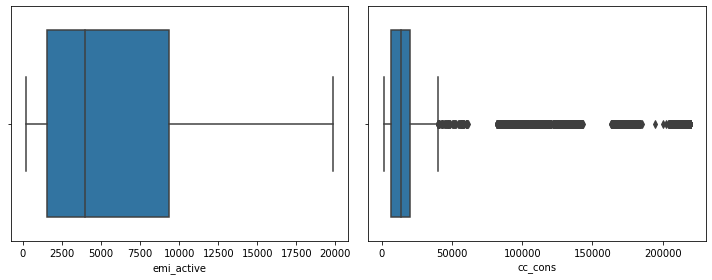

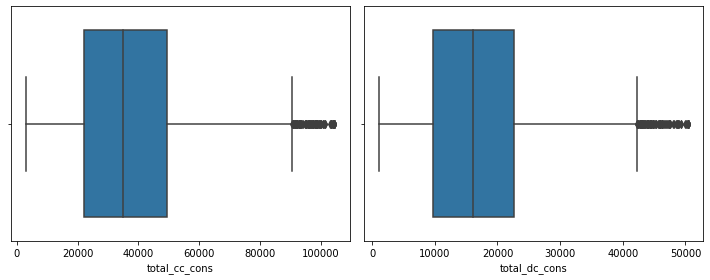

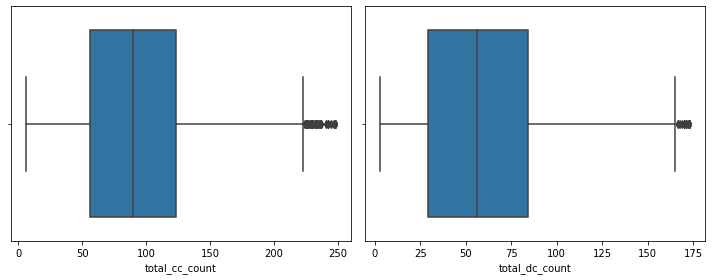

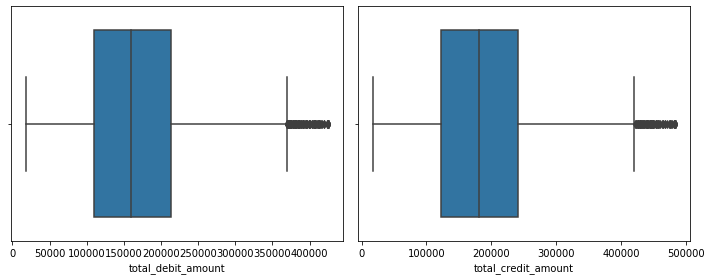

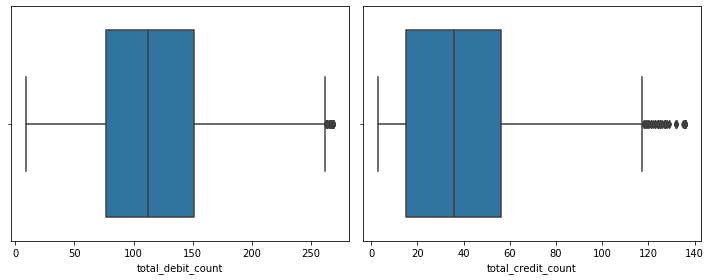

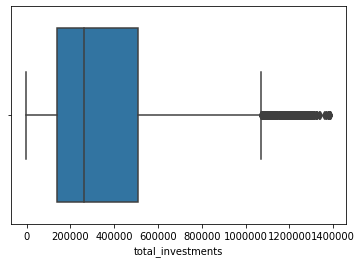

In [23]:
# Checking graphs of new DF columns

plot_continuous_columns(cdf_cleaned)            
plot_box_plots(cdf_cleaned)

In [24]:
# Applying winsorization on cleaned data and checking for outliers again.

treat_outliers(cdf_cleaned)
detect_outliers(cdf_cleaned)

,Feature,Number of Outliers
0,age,0
1,region_code,0
2,card_lim,0
3,max_credit_amount_apr,0
4,max_credit_amount_may,0
5,max_credit_amount_jun,0
6,emi_active,0
7,cc_cons,3134
8,total_cc_cons,0
9,total_dc_cons,0


In [25]:
# Rearranging columns of new data

cols = list(cdf_cleaned)
cols.insert(19,cols.pop(cols.index('cc_cons')))
cdf_cleaned = cdf_cleaned[cols]
cdf_cleaned.head()

,age,region_code,card_lim,max_credit_amount_apr,max_credit_amount_may,max_credit_amount_jun,emi_active,total_cc_cons,total_dc_cons,total_cc_count,total_dc_count,total_debit_amount,total_credit_amount,total_debit_count,total_credit_count,total_investments,cc_cons
0,35,708,430000.0,25296.0,24563.0,50836.0,1674.09,51472.40,27887.96,38.0,107.0,127498.30,210289.00,129.0,10.0,40958.30,20014.0
1,35,249,127500.0,80750.0,23948.0,23226.0,13043.34,43830.62,4512.70,21.0,55.0,146651.37,236061.37,176.0,58.0,478260.71,10173.0
2,55,802,199999.0,38466.0,10752.0,27036.0,19817.94,31599.62,11825.11,158.0,84.0,111909.25,231141.00,156.0,18.0,665166.57,16095.0
3,29,867,155000.0,52732.0,12607.0,43037.0,3544.33,60620.38,24024.44,105.0,12.0,125277.65,285812.34,164.0,74.0,349073.05,7707.0
4,34,802,297000.0,19613.0,25213.0,32044.0,12780.44,13926.40,15674.22,158.0,107.0,163395.42,169323.03,128.0,67.0,518485.80,96408.0


In [26]:
cdf_cleaned.to_csv("C:/Data Science/Jupyter Notebook/Hackathon Updated/sat_train_cleaned.csv",index=False)

# END